# 평가 조건
1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.
    - 구두점, 대소문자, 띄어쓰기 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.
2. seq2seq 기반의 번역기 모델이 정상적으로 구동된다.
    - seq2seq 모델 훈련결과를 그래프로 출력해보고, validation loss그래프가 우하향하는 경향성을 보이며 학습이 진행됨이 확인되었다.
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.
    - 테스트용 디코더 모델이 정상적으로 만들어졌으며, input(영어)와 output(프랑스어) 모두 한글로 번역해서 결과를 출력해보았고, 둘의 내용이 유사함을 확인하였다.

# 1.모듈 임포트

In [4]:
pip install unidecode

     |████████████████████████████████| 235 kB 6.7 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import re
import pandas as pd
import numpy as np
from unidecode import unidecode

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

# 2. 데이터 불러오기

In [6]:
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 217975


,eng,fra,cc
208510,"Had she known the results, she would have been...","Si elle avait connu les résultats, elle en aur...",CC-BY 2.0 (France) Attribution: tatoeba.org #1...
150557,I think that I'm going to do that.,Je pense que je ferai ça.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
27825,She hates carrots.,Elle a horreur des carottes.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
62574,I heard my dog panting.,J'ai entendu mon chien haleter.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
93498,Yesterday I played soccer.,Hier j'ai joué au foot.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...


In [7]:
del lines['cc']

In [8]:
lines = lines.sample(33000, random_state=1234)

In [9]:
lines

,eng,fra
23860,You did it again.,Tu l'as encore fait.
16283,Let's rest here.,Reposons-nous ici.
23138,We gave our word.,Nous avons donné notre parole.
102530,You won't get it so easily.,Tu ne l'obtiendras pas aussi facilement.
148689,Do you think Tom is a good singer?,Penses-tu que Tom chante bien ?
...,...,...
72770,My feet are always cold.,Mes pieds sont tout le temps froids.
8791,She is a twin.,C'est une jumelle.
90167,Many thanks for your help.,Merci beaucoup pour votre aide.
170049,"As always, you have understood poorly!","Comme toujours, tu as à peine compris !"


# 3. 데이터 전처리

1. 구둣점 분리
2. 소문자로 바꾸기
3. 띄어쓰기 단위로 토큰화를 수행
4. 디코더 데이터에 시작 토큰과 종료 토큰 넣기

### 함수를 통하여 구둣점 분리, 소문자, 띄어쓰기로 split하기

In [10]:
def Data_preprocessing(data):
    start_token = '<start>'
    end_token = '<end>'
    
    eng_list = []
    
    for sentence in data['eng']:
        sentence = sentence.lower() #소문자 변환
        sentence = re.sub(r"([?.!,¿])", r" \1", sentence) #단어와 구둣점 분리
        sentence = re.sub(r"[^a-zA-Z!.?]+", r" ", sentence) #(a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환
        sentence = re.sub(r"\s+", " ", sentence) #여러개의 공백 하나로 합치기
        sentence = sentence.split() #띄어쓰기 단위로 분리
        
        eng_list.append(sentence)
        
    fra_list = []
    
    for sentence in data['fra']:
        sentence = unidecode(sentence)
        sentence = sentence.lower() #소문자 변환
        sentence = re.sub(r"([?.!,¿])", r" \1", sentence) #단어와 구둣점 분리
        sentence = re.sub(r"[^a-zA-Z!.?]+", r" ", sentence)
        sentence = re.sub(r"\s+", " ", sentence)
    
        sentence = '<start> ' + sentence + ' <end>'
        sentence = sentence.split()
        
        fra_list.append(sentence)
        
    return eng_list, fra_list

In [11]:
eng_list, fra_list = Data_preprocessing(lines)

In [12]:
display(eng_list[:5])
display(fra_list[:5])

[['you', 'did', 'it', 'again', '.'],
 ['let', 's', 'rest', 'here', '.'],
 ['we', 'gave', 'our', 'word', '.'],
 ['you', 'won', 't', 'get', 'it', 'so', 'easily', '.'],
 ['do', 'you', 'think', 'tom', 'is', 'a', 'good', 'singer', '?']]

[['<start>', 'tu', 'l', 'as', 'encore', 'fait', '.', '<end>'],
 ['<start>', 'reposons', 'nous', 'ici', '.', '<end>'],
 ['<start>', 'nous', 'avons', 'donne', 'notre', 'parole', '.', '<end>'],
 ['<start>',
  'tu',
  'ne',
  'l',
  'obtiendras',
  'pas',
  'aussi',
  'facilement',
  '.',
  '<end>'],
 ['<start>', 'penses', 'tu', 'que', 'tom', 'chante', 'bien', '?', '<end>']]

# 4. 케라스의 토크나이저를 이용한 정수 시퀀스로 변환

In [13]:
def tokenize_transfer(eng, fra):
    eng_tokenizer = Tokenizer(char_level=True, num_words=15000) #단어 단위로 tokenizer 생성, tokenizer 수 15000만개로 제한
    fra_tokenizer = Tokenizer(char_level=True, num_words=15000) #단어 단위로 tokenizer 생성, tokenizer 수 15000만개로 제한
    
    eng_tokenizer.fit_on_texts(eng)
    fra_tokenizer.fit_on_texts(fra)
    
    eng_text = eng_tokenizer.texts_to_sequences(eng)  #단어를 숫자값 인덱스로 변환하여 저장
    fra_text = fra_tokenizer.texts_to_sequences(fra)  #단어를 숫자값 인덱스로 변환하여 저장
    
    return eng_text, fra_text, eng_tokenizer, fra_tokenizer

In [14]:
eng_text, fra_text, eng_tokenizer, fra_tokenizer = tokenize_transfer(eng_list, fra_list)

In [15]:
display(eng_text[:2])

display(fra_text[:2])

[[3, 43, 12, 128, 1], [77, 13, 503, 51, 1]]

[[1, 16, 22, 57, 114, 51, 3, 2], [1, 3564, 24, 69, 3, 2]]

### 참고사항
- from tensorflow.keras.preprocessing.text import Tokenizer안에는 위에서 전처리하였던 소문자 변환, 구둣점 분리, 띄워쓰기 단위로 split 해주는 기능이 포함되어 있음
- 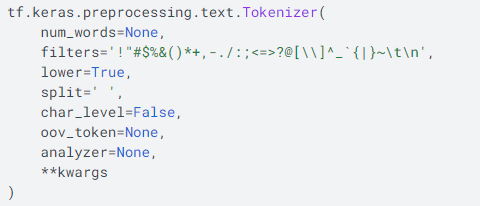

# 5.임베딩 층(Embedding layer) 사용하기

In [16]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 7961
프랑스어 단어장의 크기 : 11852


In [17]:
fra_tokenizer.word_index

{'<start>': 1,
 '<end>': 2,
 '.': 3,
 'je': 4,
 'a': 5,
 'de': 6,
 '?': 7,
 'pas': 8,
 'est': 9,
 'que': 10,
 'vous': 11,
 'la': 12,
 'ne': 13,
 'le': 14,
 'il': 15,
 'tu': 16,
 'tom': 17,
 'j': 18,
 'ce': 19,
 'n': 20,
 'un': 21,
 'l': 22,
 'ai': 23,
 'nous': 24,
 'en': 25,
 'd': 26,
 'une': 27,
 'les': 28,
 'me': 29,
 'suis': 30,
 'c': 31,
 'pour': 32,
 'qu': 33,
 'ca': 34,
 'faire': 35,
 'elle': 36,
 'dans': 37,
 '!': 38,
 'plus': 39,
 'des': 40,
 'm': 41,
 'y': 42,
 's': 43,
 'du': 44,
 'qui': 45,
 'veux': 46,
 't': 47,
 'moi': 48,
 'tout': 49,
 'te': 50,
 'fait': 51,
 'au': 52,
 'etait': 53,
 'etre': 54,
 'avec': 55,
 'se': 56,
 'as': 57,
 'si': 58,
 'mon': 59,
 'etes': 60,
 'sont': 61,
 'et': 62,
 'sur': 63,
 'cette': 64,
 'es': 65,
 'ils': 66,
 'peux': 67,
 'avez': 68,
 'ici': 69,
 'tres': 70,
 'pense': 71,
 'ou': 72,
 'son': 73,
 'sais': 74,
 'votre': 75,
 'ete': 76,
 'temps': 77,
 'pourquoi': 78,
 'dit': 79,
 'cela': 80,
 'on': 81,
 'ma': 82,
 'chose': 83,
 'lui': 84,
 'jamais

In [18]:
max_eng_seq_len = max([len(line) for line in eng_text]) #영어
max_fra_seq_len = max([len(line) for line in fra_text]) #프랑스
print('영어 시퀀스의 최대 길이:', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이:', max_fra_seq_len)

영어 시퀀스의 최대 길이: 46
프랑스어 시퀀스의 최대 길이: 57


In [19]:
start_token = '<start>'
end_token = '<end>'

encoder_input = eng_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[end_token] ] for line in fra_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[start_token] ] for line in fra_text]

In [38]:
decoder_input[:5]

array([[   1,   16,   22,   57,  114,   51,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   1, 3564,   24,   69,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   1,   24,   94,  244,  176, 1073,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   

In [20]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 46)
프랑스어 입력데이터의 크기(shape) : (33000, 57)
프랑스어 출력데이터의 크기(shape) : (33000, 57)


In [21]:
encoder_input[0]

array([  3,  43,  12, 128,   1,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32)

# 6. 모델 구현하기

In [22]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (33000, 46)
프랑스어 학습 입력데이터의 크기(shape) : (33000, 57)
프랑스어 학습 출력데이터의 크기(shape) : (33000, 57)


In [23]:
hidden_state = 256

## encoder

In [24]:
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(input_dim= eng_vocab_size, output_dim = hidden_state, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(hidden_state, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

## decoder

In [25]:
#decoder 입력층
decoder_inputs = Input(shape=(None,))
decoder_embedding  = Embedding(input_dim=fra_vocab_size, output_dim =hidden_state, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(hidden_state, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding , initial_state=encoder_states)

#decoder 출력층
decoder_softmax_layer  = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [26]:
#model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    2038016     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    3034112     input_2[0][0]                    
______________________________________________________________________________________________

In [27]:
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
235/235 [==============================] - 38s 73ms/step - loss: 0.8930 - val_loss: 0.7602
Epoch 2/50
235/235 [==============================] - 15s 64ms/step - loss: 0.7206 - val_loss: 0.6790
Epoch 3/50
235/235 [==============================] - 15s 65ms/step - loss: 0.6366 - val_loss: 0.6128
Epoch 4/50
235/235 [==============================] - 16s 66ms/step - loss: 0.5717 - val_loss: 0.5662
Epoch 5/50
235/235 [==============================] - 16s 67ms/step - loss: 0.5225 - val_loss: 0.5342
Epoch 6/50
235/235 [==============================] - 16s 68ms/step - loss: 0.4835 - val_loss: 0.5098
Epoch 7/50
235/235 [==============================] - 16s 69ms/step - loss: 0.4499 - val_loss: 0.4900
Epoch 8/50
235/235 [==============================] - 16s 68ms/step - loss: 0.4193 - val_loss: 0.4729
Epoch 9/50
235/235 [==============================] - 16s 68ms/step - loss: 0.3910 - val_loss: 0.4594
Epoch 10/50
235/235 [==============================] - 16s 68ms/step - loss: 0.364

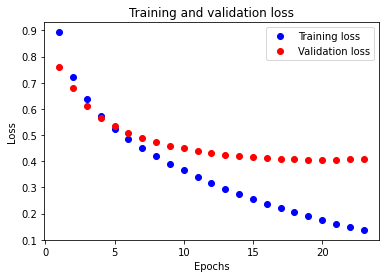

In [28]:
history_dict = history.history

# acc = history_dict['accuracy']
# val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

his_epochs = range(1, len(loss) + 1)

plt.plot(his_epochs, loss, 'bo', label='Training loss')
plt.plot(his_epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 7. 모델 평가하기

## encoder

In [29]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         2038016   
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 525312    
Total params: 2,563,328
Trainable params: 2,563,328
Non-trainable params: 0
_________________________________________________________________


## decoder

In [30]:
decoder_state_input_h = Input(shape=(hidden_state,))
decoder_state_input_c = Input(shape=(hidden_state,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder_embedding2  = Embedding(input_dim=fra_vocab_size,output_dim =hidden_state)(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(decoder_embedding, initial_state = decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)

In [31]:
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs2] + decoder_states2)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    3034112     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

In [32]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [43]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = fra2idx['<start>']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '<end>' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [44]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + idx2eng[i]+' '
    return temp

In [47]:
# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=fra2idx['<start>']) and i!=fra2idx['<end>']):
            temp = temp + idx2fra[i] + ' '
    return temp

In [53]:
import numpy as np
for seq_index in [3,71,350,1498,2611]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', seq2src(encoder_input_test[seq_index]))
    print('정답 문장:', seq2tar(decoder_input_test[seq_index]))
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-5])

-----------------------------------
입력 문장: your name is still on the list . 
정답 문장: ton nom est toujours sur la liste . 
번역기가 번역한 문장:  ton nom est toujours sur le canape . 
-----------------------------------
입력 문장: tom passed most of the time fishing . 
정답 문장: tom passait le plus clair de son temps a pecher . 
번역기가 번역한 문장:  tom est la plus jeune de la guitare . 
-----------------------------------
입력 문장: i feel so alive right now . 
정답 문장: je me sens tellement en vie en ce moment . 
번역기가 번역한 문장:  je me sens tellement en train de comprendre ca . 
-----------------------------------
입력 문장: i just have to keep working . 
정답 문장: je dois seulement continuer a travailler . 
번역기가 번역한 문장:  je viens juste d aller a faire . 
-----------------------------------
입력 문장: my father bought me a bicycle . 
정답 문장: mon pere m acheta un velo . 
번역기가 번역한 문장:  mon pere m a achete un velo . 


## 번역결과
-----------------------------------

- 입력 문장: your name is still on the list .  / 해석:당신의 이름은 여전히 목록에 있습니다.
- 정답 문장: ton nom est toujours sur la liste . / 해석:네 이름이 아직도 명부에 올라 있다.
- 번역기가 번역한 문장:  ton nom est toujours sur le canape . / 해석:네 이름이 아직도 오리발이다.

-----------------------------------

- 입력 문장: tom passed most of the time fishing . / 해석:톰은 대부분의 시간을 낚시로 보냈습니다.
- 정답 문장: tom passait le plus clair de son temps a pecher . / 해석: 톰이 그의 시간의 대부분을 허비하고 있었습니다.
- 번역기가 번역한 문장:  tom est la plus jeune de la guitare . / 해석: 탐은 기타 중에서 가장 어립니다.

-----------------------------------

- 입력 문장: i feel so alive right now . / 해석: 저는 지금 너무 살아있는 것 같아요.
- 정답 문장: je me sens tellement en vie en ce moment . / 해석: 저는 지금 너무 살아있음을 느낍니다.
- 번역기가 번역한 문장:  je me sens tellement en train de comprendre ca . / 해석: 그 말을 들으니 마음이 착잡하다.

-----------------------------------

- 입력 문장: i just have to keep working . / 해석: 저는 그냥 계속 일을 해야 합니다.
- 정답 문장: je dois seulement continuer a travailler . / 해석: 저는 일을 계속해야 합니다.
- 번역기가 번역한 문장:  je viens juste d aller a faire . / 해석: 이제 막 일을 하러 갔어요.

-----------------------------------

- 입력 문장: my father bought me a bicycle . / 해석: 나의 아버지는 나에게 자전거를 사주셨습니다.
- 정답 문장: mon pere m acheta un velo . / 해석: 우리 아빠는 벨로를 사셨다.
- 번역기가 번역한 문장:  mon pere m a achete un velo . / 해석: 우리 아빠는 벨로를 사셨다.

### 기존 단어장 크기 및 max_length
- 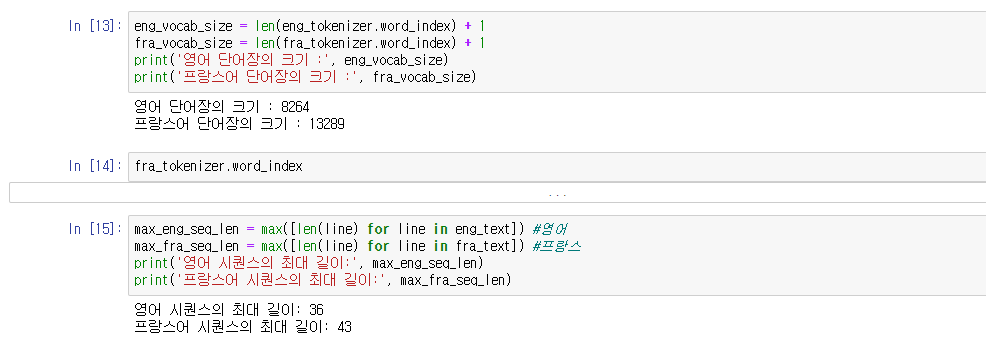

### adam으로 돌렸을때의 결과(글자수 max)
- 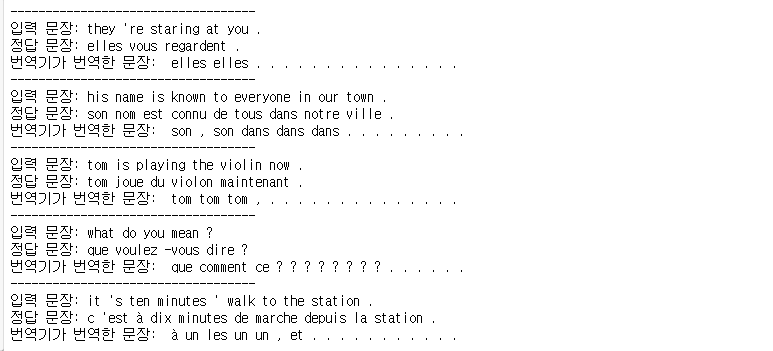

### adam(글자 수 절반)
- 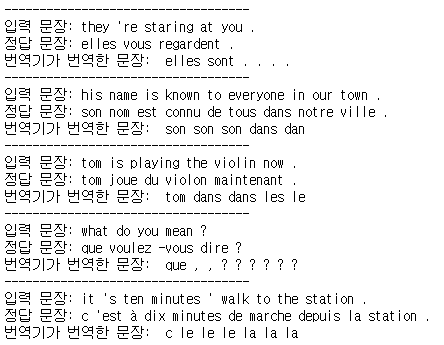

### rsmprop(글자 수 작게)
- 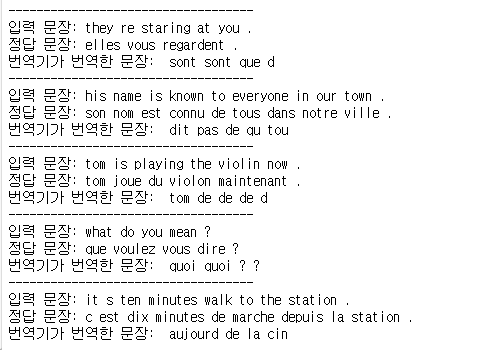

# 전체 회고
- 위에는 처음에 내가 시도했던 방법들이다.
- 다른 그루분들과 얘기해보니 나의 단어장 크기나 max_length의 길이가 터무니 없이 컸다.
- 데이터를 확인하였을때 앞쪽에는 'go' 같은 짧은 단어들이 많아서 sample을 이용하여 랜덤으로 뽑았고, 그렇게 해서 돌려도 될 줄 알았지만, 위와 같이 번역된 결과를 보면 제대로 해석했다고 할 수 있는 문장들이 별로 없다.
- 나는 내가 잘못된줄 알고 여러가지 방법을 시도하였다.
1. 전처리 수정
    - sample을 할때 random_state 정수
    - sample 사용 안하고 그냥 뽑기
    - 프랑스어 악센트 제거
    - re.sub 수정
2. 모델 노드 수 수정
3. mask_zero = True
4. Masking layer 추가
5. max_length 임의로 변경

- 결국 다시 했을때에도 단어장의 크기는 남들의 두배였고, max_length 길이도 2배였다.
- 솔직히 다시 바꾼거라고 sample을 할때 random_state 정수를 42에서 1234로 바꾼것과 embedding layer에 mask_zero = True를 추가한것 밖에 없다.
- 하지만 처음에 따로 Masking layer을 따로 추가하였는데, 성능이 좋지 않았다.
- mask_zero = True와 Masking layer의 성능 및 쓰임새가 다르다는것을 처음 알았다.
- 내가 생각했을때는 그냥 0이면 연산에서 제외하겠다는 것인데, 이것이 성능을 좋게 할지는 몰랐다.
- 여러 사람들의 코드를 보면서 내것으로 차용하려는 시도를 많이 해본것 같다.
- 이번 exploration은 참 재미있었던것 같다.

## 참고자료
- https://wikidocs.net/86900
- https://wikidocs.net/24996
- https://didu-story.tistory.com/107